# -----------------------------librerías extra

In [1]:
using ProgressMeter
using Cubature
using PyPlot

In [2]:
using Graf
using nintegrate

### ----------------------------constantes

### ----------------------------

In [3]:
const m = 1.0;
const hbarr = 1.0;
#n = 1.;
const omegaz = 0.05;
const omegar = 7.0*omegaz;
const n=1.;
const alfa=10.0;
const g_alfa=4.0*π*alfa;
const omegam=(omegar*omegaz)^(1/3);
const mu=0.5*omegam*(15*alfa*sqrt(m*omegam))^(2.0/5.0);

const c = sqrt(n*g_alfa/m);

### -------------

### -------------parámetros característicos del solitón bosónico

In [23]:
ksi=0.9;
beta=0.7;
algo=3.0
z0=algo*ksi;
gama=1/(sqrt(1-beta^2));

In [24]:
gama

1.4002800840280099

### ----Función de onda

In [25]:

function N(t::Float64)
    (1/sqrt(2*pi))*(m/hbarr)^(3/2)*(omegar/sin(omegar*t))*sqrt(omegaz/sin(omegaz*t))
end

function sol(z::Float64)
(tanh((z-z0)/(ksi*gama)))/gama
end


function fase_rr1(r::Float64,r1::Float64,t::Float64)
    (m*omegar/(2*hbarr))*(r1^2+r^2)/tan(omegar*t)+ pi/4
end

function fase_zz1(z::Float64,z1::Float64,t::Float64)
    (m*omegaz/(2*hbarr))*((z1^2+z^2)/tan(omegaz*t)-2*z*z1/sin(omegaz*t))
end

function Rre(r::Float64,r1::Float64,t::Float64)
    besselj0(-m*omegar*r*r1/(hbarr*sin(omegar*t)))*r1*cos(fase_rr1(r,r1,t))
end

function Rim(r::Float64,r1::Float64,t::Float64)
    besselj0(-m*omegar*r*r1/(hbarr*sin(omegar*t)))*r1*sin(fase_rr1(r,r1,t))
end

function Zre(z::Float64,z1::Float64,t::Float64)
    cos(fase_zz1(z,z1,t))*sol(z1)-beta*sin(fase_zz1(z,z1,t))
end

function Zim(z::Float64,z1::Float64,t::Float64)
    sin(fase_zz1(z,z1,t))*sol(z1)+beta*cos(fase_zz1(z,z1,t))
end

function U(r::Float64,z::Float64)
    (1/2)*m*((omegar*r)^2 + (omegaz*z)^2)
end

function n_tf(r::Float64,z::Float64)            
    if  mu-U(r,z)>0 0
        return (mu-U(r,z))/(n*g_alfa)              
    end
    return 0       
end




n_tf (generic function with 1 method)

In [26]:
const rmaxintegrar=sqrt(2*mu/m)/omegar;
const rminintegrar=0;
const zmaxintegrar=sqrt(2*mu/m)/omegaz;
const zminintegrar=-sqrt(2*mu/m)/omegaz;

rmaxevaluar=rmaxintegrar;
rminevaluar=0.0;
zmaxevaluar=zmaxintegrar;
zminevaluar=-zmaxevaluar;


# Reglas para sumar índices

In [27]:
function valor_i_abajo(i::Int64,di::Int64)

    if  i-di>=1
        return i-di
    end
    
    return 1;        
end



function valor_i_arriba(i::Int64,di::Int64,iteraciones_maximas::Int64)

    if  i+di>=iteraciones_maximas
        return iteraciones_maximas
    end
    
    return i+di;        
end

valor_i_arriba (generic function with 1 method)

In [28]:
function mapear_funcion_2d_y_t(f::Function,iteracionesx::Integer,xmin::Float64,Dx::Float64,iteracionesy::Integer,ymin::Float64,Dy::Float64,iteracionestiemp::Integer,Dt::Float64)
    mapeado=zeros(iteracionesx+1,iteracionesy+1,iteracionestiemp)
   
    for l in 1:iteracionestiemp

        t=Dt*l
       
        for i in 1:iteracionesx+1
            x=(i-1)*Dx+xmin   

           
            for j in 1:iteracionesy+1
                y=(j-1)*Dy+ymin;    
                #println("r1=$r1")
                mapeado[i,j,l]=f(x,y,t);    
            end    
        
        end
    end

    return mapeado
end

mapear_funcion_2d_y_t (generic function with 1 method)

# Propagar Perfil inicial

# ----------------------------------------------------------------------------------------------

In [29]:
# EL TIEMPO
t0=1/sqrt(omegar^2+omegaz^2);
DT=10;
t0=t0/DT;

#Parámetros de resolución

In [30]:
iteracionest=10

divisiones=5;

iteracionesr=Integer(100);
iteracionesz=Integer(100);

iteracionesr1=iteracionesr+(divisiones-1)*(iteracionesr-1);
iteracionesz1=iteracionesz+(divisiones-1)*(iteracionesz-1);

Dr1=(rmaxintegrar-rminintegrar)/iteracionesr1;
Dz1=(zmaxintegrar-zminintegrar)/iteracionesz1;

Dr=(rmaxevaluar-rminevaluar)/iteracionesr;
Dz=(zmaxevaluar-zminevaluar)/iteracionesz;



#################NO SE TOMAN TODOS LOS ÍNDICES DE INTEGRACIÓN, SÓLO ALGUNOS cercanos al punto dado
#Dr1_omegar=sqrt(hbarr/(m*omegar)); #Dr1_omegar>Dr1
#Dz1_omegaz=sqrt(hbarr/(m*omegaz)); #Dz1_omegaz>Dr1

Dr1_omegar=Dr1*20;
Dz1_omegaz=Dz1*20;

############valores en índices
dzl0=    round(Integer,Dz1_omegaz/Dz1);
drk0=    round(Integer,Dr1_omegar/Dr1); #a lo más, se va a integrar 2*drk0*N_arbitrario puntos+1 al rededor de un punto dado (contando al punto)
###########################################################################



20

## Arreglos prehechos para guardar todo:

In [31]:
fRre=mapear_funcion_2d_y_t(Rre,iteracionesr,0.0,Dr,iteracionesr1,0.0,Dr1,iteracionest,t0);
fRim=mapear_funcion_2d_y_t(Rim,iteracionesr,0.0,Dr,iteracionesr1,0.0,Dr1,iteracionest,t0);
gZre=mapear_funcion_2d_y_t(Zre,iteracionesz,zminevaluar,Dz,iteracionesz1,zminintegrar,Dz1,iteracionest,t0);
gZim=mapear_funcion_2d_y_t(Zim,iteracionesz,zminevaluar,Dz,iteracionesz1,zminintegrar,Dz1,iteracionest,t0);

ReIntegral=zeros(iteracionesr+1,iteracionesz+1,iteracionest);
ImIntegral=zeros(iteracionesr+1,iteracionesz+1,iteracionest);
Z=zeros(iteracionesr+1,iteracionesz+1,iteracionest);


In [ ]:
q=Progress(iteracionest+1,1)
for τ in 1:iteracionest
    t=τ*t0
    

    p=Progress(iteracionesr+1,1)
    for i in 1: iteracionesr+1
            
        #println("i====================$i") 
        r=(i-1)*Dr;    
       #println("r=============================================$r") 
            
      


        for j in 1: iteracionesz+1
        #println("j===========$j") 
            z=zminevaluar+(j-1)*Dz;    
            #println("z======================$z") 

        
          i1=i+(divisiones-1)*(i-1);
        kmin= valor_i_abajo(i1,drk0); #i-Dr1 expresado en la malla de integración con reglas
        kmax= valor_i_arriba(i1,drk0,iteracionesr1); #i1+Dr1 con reglas

            
            j1=j+(divisiones-1)*(j-1);    
            lmin= valor_i_abajo(j1,dzl0);  #j-Dz1 expresado en la malla de integración con reglas
            lmax= valor_i_arriba(j1,dzl0,iteracionesz1); #j+Dz1 expresado en la malla de integración con reglas

            
          
            for k in kmin: kmax #induce error de redondeo    
                #for k in 1: iteracionesr1+1
                    r1=(k-1)*Dr1;

           # println("k====$k") 
                    #println("r1===============$r1")
                    #println("kmax====$(indicializar(r1_maximo,rminintegrar,Dr1))")

                    #println("r1===","$r1")

                for l in lmin: lmax #induce error de redondeo
                    #for l in 1:iteracionesz1+1
               # println("l==$l")   


                            #println("$(indicializar(r1_minimo,rminintegrar,Dr1))", "$(indicializar(r1_maximo,rminintegrar,Dr1))")

                            #println("lmin==$(indicializar(z1_minimo,zminintegrar,Dz1))")
                            #println("lmax==$(indicializar(r1_minimo,zminintegrar,Dz1))")

                            
                    z1=zminevaluar+(l-1)*Dz1;
                            #println("z1====$z1")

                            #println("z1=","$z1")




                            #Llamando los arreglos ya hechos para mapear las funciones en r,r1 y en z,z1:

                            ReIntegral[i,j,τ]=ReIntegral[i,j,τ]+n_tf(r1,z1)*(fRre[i,k,τ]*gZre[j,l,τ]-fRim[i,k,τ]*gZim[j,l,τ])*Dr1*Dz1;   
                            ImIntegral[i,j,τ]=ImIntegral[i,j,τ]+n_tf(r1,z1)*(fRre[i,k,τ]*gZim[j,l,τ]+fRim[i,k,τ]*gZre[j,l,τ])*Dr1*Dz1;


                            #Sin llamar los arreglos ya hechos para mapear las funciones en r,r1 y en z,z1:
                            #ReIntegral[i,j,τ]=ReIntegral[i,j,1]+n_tf(r1,z1)*(Rre(r,r1,t)*Zre(z,z1,t)-Rim(r,r1,t)*Zim(z,z1,t))*Dr1*Dz1;
                            #ImIntegral[i,j,τ]=ReIntegral[i,j,1]+n_tf(r1,z1)*(Rre(r,r1,t)*Zim(z,z1,t)+Rim(r,r1,t)*Zre(z,z1,t))*Dr1*Dz1;
            
            
            
            
            
                            #Si QUIERES usar los programas anteriores debes quitar las integraciones en k y l y usar:
                               #f(v)=real_funcion_a_integrar(v,r,z,t);
                               #g(v)=imag_funcion_a_integrar(v,r,z,t);
                            
                            
                                #(val,err) = hcubature(f,[rminintegrar,zminintegrar],[rmaxintegrar,zmaxintegrar]; reltol=1e-6, abstol=1e-6, maxevals=100000);
                                #(val2,err) = hcubature(g,[rminintegrar,zminintegrar],[rmaxintegrar,zmaxintegrar]; reltol=1e-6, abstol=1e-6, maxevals=100000);
                            
                                #ReIntegral[i,j,τ]=val
                                #ImIntegral[i,j,τ]=val2    
          
                    end 
        
            end
        end
        next!(p)
    end
    

    Z[:,:,τ]=N(t)^2*(ReIntegral[:,:,τ].^2+ImIntegral[:,:,τ].^2);
   grafdensidad([zminevaluar,zmaxevaluar],[rminevaluar,rmaxevaluar],iteracionesr+1,Z[:,:,τ],"Perfil Propagado a t=$τ *T0/$DT","z","r")    
    savefig("fig$τ entre $DT con $drk0 de r y $dzl0 de z resol de $iteracionesz*$iteracionesr.png")

    next!(q)

end

Progress:  52%  ETA: 0:00:30

In [22]:
beta

0.2

# ----------------------------------------------------------------------------------------------

#El perfil inicial 

## líneas de nivel

for i in 1:100
    z=linspace(zmin,zmax,resolucion)
    PyPlot.plot(z,perfilinicial[i,:]')
    PyPlot.xlabel("z")
    PyPlot.ylabel("ρ")
    PyPlot.title("dejando r constante y variando z")
    #PyPlot.legend("$i")
end

for i in 1:100
        r=linspace(0,rmax,resolucion)

    PyPlot.plot(r,perfilinicial[:,i])
    #PyPlot.legend("$i")
    PyPlot.xlabel("r")
    PyPlot.ylabel("ρ")
    PyPlot.title("Dejando z constante y variando r")
end

In [190]:
rmaxintegrar

3.4654354776049505

## Es lo mismo que con las hcubature (faltan las expresiones en forma vectorial):

In [ ]:
ReIntegralcubature=zeros(iteracionesr+1,iteracionesz+1,iteracionest);
ImIntegralcubature=zeros(iteracionesr+1,iteracionesz+1,iteracionest);
Zcubature=zeros(iteracionesr+1,iteracionesz+1,iteracionest);


In [ ]:
pasosdetiempo=[1,5,10]

In [ ]:
q=Progress(iteracionest+1,1)
for τ in pasosdetiempo
    t=τ*t0
    

    p=Progress(iteracionesr+1,1)
    for i in 1: iteracionesr+1
            
        #println("i====================$i") 
        r=(i-1)*Dr;    
       #println("r=============================================$r") 


        for j in 1: iteracionesz+1
            #println("j===========$j") 
            z=zminevaluar+(j-1)*Dz;    
            #println("z======================$z") 

        
            
            
          #  r1_minimo=valor_r1_abajo(r,Dr1_omegar); #r+Dr1_omegar con reglas
          #  r1_maximo=valor_r1_arriba(r,Dr1_omegar,rmaxintegrar); #r-Dr1_omegar con reglas

          #  z1_minimo=valor_z1_abajo(z,Dz1_omegaz,zminintegrar); #z-Dz1_omegaz con reglas
          #  z1_maximo=valor_z1_arriba(z,Dz1_omegaz,zmaxintegrar); #z+Dz1_omegaz con reglas



            
            
            
            
            
            
        
            #for k in indicializar_abajo(r1_minimo,rminintegrar,Dr1): indicializar_arriba(r1_maximo,rminintegrar,Dr1)+1 #induce error de redondeo    
                #for k in 1: iteracionesr1+1
            #        r1=(k-1)*Dr1;

                    #println("k====$k") 
                    #println("r1===============$r1")
                    #println("kmax====$(indicializar(r1_maximo,rminintegrar,Dr1))")

                    #println("r1===","$r1")

            #   for l in indicializar_abajo(z1_minimo,zminintegrar,Dz1): indicializar_arriba(z1_maximo,zminintegrar,Dz1)+1 #induce error de redondeo
                    #for l in 1:iteracionesz1+1
                        #println("l==$l")   


                            #println("$(indicializar(r1_minimo,rminintegrar,Dr1))", "$(indicializar(r1_maximo,rminintegrar,Dr1))")

                            #println("lmin==$(indicializar(z1_minimo,zminintegrar,Dz1))")
                            #println("lmax==$(indicializar(r1_minimo,zminintegrar,Dz1))")

                            
             #       z1=zminevaluar+(l-1)*Dz1;
                            #println("z1====$z1")

                            #println("z1=","$z1")




                            #Llamando los arreglos ya hechos para mapear las funciones en r,r1 y en z,z1:

             #               ReIntegral[i,j,τ]=ReIntegral[i,j,τ]+n_tf(r1,z1)*(fRre[i,k,τ]*gZre[j,l,τ]-fRim[i,k,τ]*gZim[j,l,τ])*Dr1*Dz1;   
             #               ImIntegral[i,j,τ]=ImIntegral[i,j,τ]+n_tf(r1,z1)*(fRre[i,k,τ]*gZim[j,l,τ]+fRim[i,k,τ]*gZre[j,l,τ])*Dr1*Dz1;


                            #Sin llamar los arreglos ya hechos para mapear las funciones en r,r1 y en z,z1:
                            #ReIntegral[i,j,τ]=ReIntegral[i,j,1]+n_tf(r1,z1)*(Rre(r,r1,t)*Zre(z,z1,t)-Rim(r,r1,t)*Zim(z,z1,t))*Dr1*Dz1;
                            #ImIntegral[i,j,τ]=ReIntegral[i,j,1]+n_tf(r1,z1)*(Rre(r,r1,t)*Zim(z,z1,t)+Rim(r,r1,t)*Zre(z,z1,t))*Dr1*Dz1;
            
            
            
            
            
                            #Si QUIERES usar los programas anteriores debes quitar las integraciones en k y l y usar:
                               f(v)=real_funcion_a_integrar(v,r,z,t);
                               g(v)=imag_funcion_a_integrar(v,r,z,t);
                            
                            
                                (val,err) = hcubature(f,[rminintegrar,zminintegrar],[rmaxintegrar,zmaxintegrar]; reltol=1e-6, abstol=1e-6, maxevals=100000);
                                (val2,err) = hcubature(g,[rminintegrar,zminintegrar],[rmaxintegrar,zmaxintegrar]; reltol=1e-6, abstol=1e-6, maxevals=100000);
                            
                                ReIntegralcubature[i,j,τ]=val
                                ImIntegralcubature[i,j,τ]=val2    
          
                    end 
        
            end
        end
        next!(p)
    end
    

    Zcubature[:,:,τ]=N(t)^2*(ReIntegral[:,:,τ].^2+ImIntegral[:,:,τ].^2);
    grafdensidad([zminevaluar,zmaxevaluar],[rminevaluar,rmaxevaluar],iteracionesr+1,Zcubature[:,:,τ],"Perfil Propagado a t=$τ *T0/$DT","z","r")    
    savefig("fig$τ entre $DT con $drk0 de r y $dzl0 de z resol de $iteracionesz*$iteracionesr cubature.png")

    next!(q)

end

In [22]:
const xminI=[0.0, -sqrt(2*mu/m)/omegaz];
const xmaxI=[sqrt(2*mu/m)/omegar, sqrt(2*mu/m)/omegaz];

ψr10t0=nintegrar4Dmasunoa2Dmasuno(Φ_real_entreNt,[zminevaluar,zmaxevaluar],[rminevaluar,rmaxevakyar],10*t0,xminI,xmaxI,100,100);
ψi10t0=nintegrar4Dmasunoa2Dmasuno(Φ_imag_entreNt,[zminevaluar,zmaxevaluar],[rminevaluar,rmaxevakyar],10*t0,xminI,xmaxI,100,100);


LoadError: rmaxevakyar not defined
while loading In[22], in expression starting on line 4

In [92]:
p=Progress(iteracionesr+1,1)

tic()

for i in 1: iteracionesr+1
    #println("i====================$i") 
    r=(i-1)*Dr;    
   

    for j in 1: iteracionesz+1
        #println("j===========$j") 
        z=zminevaluar+(j-1)*Dz;    




        #for k in indicializar_abajo(r1_minimo,rminintegrar,Dr1): indicializar_arriba(r1_maximo,rminintegrar,Dr1) #induce error de redondeo    
        for k in 1: iteracionesr1+1
            r1=(k-1)*Dr1;
            
            #println("k====$k") 
            #println("kmin====$(indicializar(r1_minimo,rminintegrar,Dr1))")
            #println("kmax====$(indicializar(r1_maximo,rminintegrar,Dr1))")

            #println("r1===","$r1")

            #for l in indicializar_abajo(z1_minimo,zminintegrar,Dz1): indicializar_arriba(z1_maximo,zminintegrar,Dz1) #induce error de redondeo
            for l in 1:iteracionesz1+1
            #println("l==$l")   

                #println("$(indicializar(r1_minimo,rminintegrar,Dr1))", "$(indicializar(r1_maximo,rminintegrar,Dr1))")

                #println("lmin==$(indicializar(z1_minimo,zminintegrar,Dz1))")
                #println("lmax==$(indicializar(r1_minimo,zminintegrar,Dz1))")
                
                z1=zminintegrar+(l-1)*Dz1;

                #println("z1=","$z1")
             
                
                
                
                #Llamando los arreglos ya hechos para mapear las funciones en r,r1 y en z,z1:
                    
                ReIntegral[i,j]=n_tf(r1,z1)*(fRre[i,k]*gZre[j,l]-fRim[i,k]*gZim[j,l])*Dr1*Dz1;   
                ImIntegral[i,j]=n_tf(r1,z1)*(fRre[i,k]*gZim[j,l]+fRim[i,k]*gZre[j,l])*Dr1*Dz1;
            
            
                #Sin llamar los arreglos ya hechos para mapear las funciones en r,r1 y en z,z1:
                #   ReIntegral[i,j]=n_tf(r1,z1)*(Rre(r,r1,t)*Zre(z,z1,t)-Rim(r,r1,t)*Zim(z,z1,t))*Dr1*Dz1;
                 #  ImIntegral[i,j]=n_tf(r1,z1)*(Rre(r,r1,t)*Zim(z,z1,t)+Rim(r,r1,t)*Zre(z,z1,t))*Dr1*Dz1;
            end
        
        end
        
  
    end

    next!(p)
end

toc()

Progress: 100% Time: 1:14:25
elapsed time: 4464.601745732 seconds


4464.601745732

In [19]:
ReIntegral

101x101 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

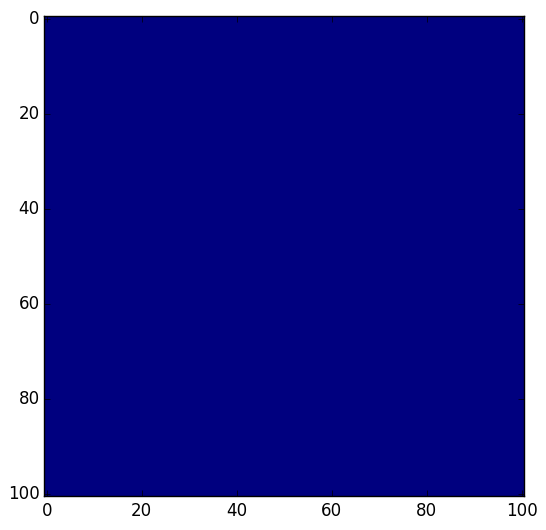

PyObject <matplotlib.image.AxesImage object at 0x7fd3832ce7d0>

In [93]:
Z=ReIntegral.^2+ImIntegral.^2
imshow(Z)

# esto

In [86]:
tic()
ψr_entre_10=nintegrar4Dmasunoa2Dmasuno(Φ_real_entreNt,[0.0,rmaxevaluar],[zminevaluar,zmaxevaluar],t0/10,[0.0,zminintegrar],[rmaxintegrar,zmaxintegrar],100,100);
toc()

Progress: 100% Time: 1:14:35
te da una matríz Z de 101 X 101 donde Z(i->x,j->y) son los puntos integrados de g 
elapsed time: 4474.746841809 seconds


4474.746841809

In [87]:
tic()
ψi_entre_10=nintegrar4Dmasunoa2Dmasuno(Φ_real_entreNt,[0.0,rmaxevaluar],[zminevaluar,zmaxevaluar],10*t0,[0.0,zminintegrar],[rmaxintegrar,zmaxintegrar],100,100);
toc()

Progress: 100% Time: 1:16:41
te da una matríz Z de 101 X 101 donde Z(i->x,j->y) son los puntos integrados de g 
elapsed time: 4601.005729074 seconds


4601.005729074

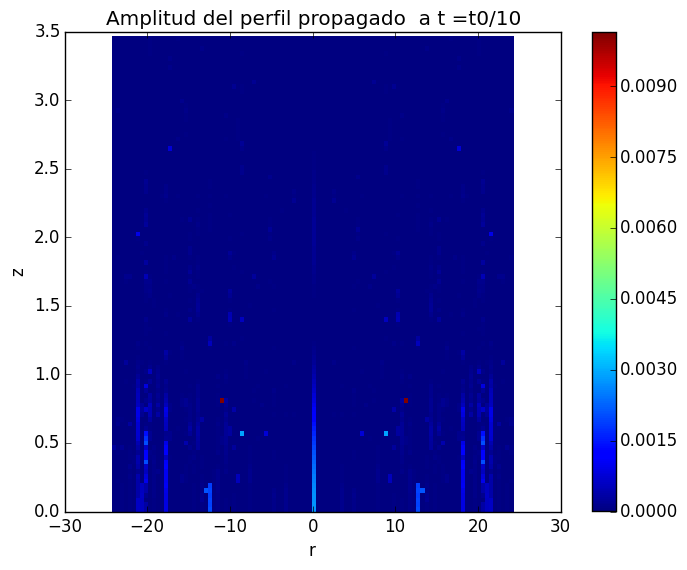

PyObject <matplotlib.colorbar.Colorbar instance at 0x7fd383658290>

In [88]:
F_entre_10=(ψr10.^2+ψi10.^2)*N(10*t0)^2;
grafdensidad([zminevaluar,zmaxevaluar],[rminevaluar,rmaxevaluar],iteracionesr+1,F10,"Amplitud del perfil propagado  a t =t0/10","r","z")

# también

In [64]:
ψr5=nintegrar4Dmasunoa2Dmasuno(Φ_real_entreNt,[0.0,rmaxevaluar],[zminevaluar,zmaxevaluar],5*t0,[0.0,zminintegrar],[rmaxintegrar,zmaxintegrar],100,100);

Progress: 100% Time: 0:48:11
te da una matríz Z de 101 X 101 donde Z(i->x,j->y) son los puntos integrados de g 


In [65]:
ψi5=nintegrar4Dmasunoa2Dmasuno(Φ_real_entreNt,[0.0,rmaxevaluar],[zminevaluar,zmaxevaluar],5*t0,[0.0,zminintegrar],[rmaxintegrar,zmaxintegrar],100,100);


Progress: 100% Time: 0:49:10
te da una matríz Z de 101 X 101 donde Z(i->x,j->y) son los puntos integrados de g 


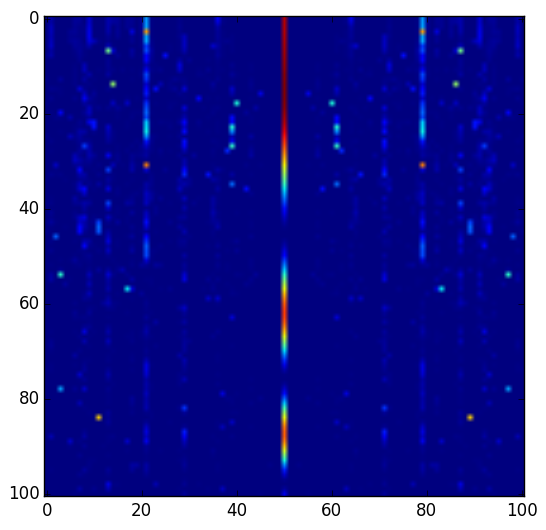

PyObject <matplotlib.image.AxesImage object at 0x7fd386870210>

In [66]:
F5=(ψr5.^2+ψi5.^2)*N(5*t0)^2;
imshow(F5)

### y siguen faltando...

p=Progress(iteracionesr+1,1)
for i in 1: iteracionesr+1
    r=(i-1)*Dr;    
    #println("r==========$i")
    for j in 1: iteracionesz+1
        z=zminevaluar+(j-1)*Dz;
        #println("z=====$j")
        for k in 1: drk0
        #for k in 1:iteracionesr1+1     
            r1=(k-1)*Dr1;
            #println("r1===$k")
            for l in l0-Numz: l0+Numz
            #for l in 1:iteracionesz1+1
                z1=zminintegrar+(l-1)*Dz1;
                #println("z1=$l")
                
                #Llamando los arreglos ya hechos para mapear las funciones en r,r1 y en z,z1:
                ReIntegral[i,j]=ReIntegral[i,j]+integrarfunción de onda en todo el dominio de r1,z1;
                ImIntegral[i,j]=ImIntegral[i,j]+integrarfunción de onda en todo el dominio de r1,z1;
            
            
                #Sin llamar los arreglos ya hechos para mapear las funciones en r,r1 y en z,z1:
                #ReIntegral[i,j]=ReIntegral[i,j]+n_tf(r1,z1)*(Rre(r,r1,t)*Zre(z,z1,t)-Rim(r,r1,t)*Zim(z,z1,t))*Dr1*Dz1;
                #ImIntegral[i,j]=ImIntegral[i,j]+n_tf(r1,z1)*(fRre[i,k]*gZim[j,l]+fRim[i,k]*gZre[j,l])*Dr1*Dz1;
            end
        
        end
        
    end

    next!(p)
end


ReIntegral=ReIntegral*N(t);
ImIntegral=ImIntegral*N(t);

Z=ReIntegral.^2+ImIntegral.^2;
grafdensidad([zminevaluar,zmaxevaluar],[rminevaluar,rmaxevaluar],101,Z,"eso","z","r")    

In [101]:
typeof([1,2,3])

Array{Int64,1}

vectorizar_funcion_2_variables (generic function with 1 method)

In [121]:
f(x,y,z,t)=x^2+y^2;

g(v)=vectorizar_funcion_4_variables(f,v)

g (generic function with 1 method)

In [126]:
methods(Zre)

# 1 method for generic function "Zre":
Zre(z::Float64,z1::Float64,t::Float64) at In[4]:28